In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import tensorflow as tf
from tensorflow.contrib.layers import flatten
from sklearn.utils import shuffle
import pandas as pd
import numpy as np
import cv2
import pickle

In [3]:
training_file = "data/train.p"
validation_file= "data/valid.p"
testing_file = "data/test.p"

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(validation_file, mode='rb') as f:
    valid = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)

#Set Train, Validation and Test Data
X_train, y_train = train['features'], train['labels']
X_valid, y_valid = valid['features'], valid['labels']
X_test, y_test = test['features'], test['labels']

#read signnames file
signnames = pd.read_csv("data/signnames.csv")

#Number of examples for training, validation and testing
n_train = len(X_train)
n_validation = len(X_valid)
n_test = len(X_test)

#The shape of an traffic sign image
image_shape = X_train.shape[1:3]

#How many unique classes/labels there are in the dataset.
n_classes = len(signnames)

print("Number of training examples =", n_train)
print("Number of validation examples =", n_validation)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

Number of training examples = 34799
Number of validation examples = 4410
Number of testing examples = 12630
Image data shape = (32, 32)
Number of classes = 43


In [4]:
signnames.head(43)

,ClassId,SignName
0,0,Speed limit (20km/h)
1,1,Speed limit (30km/h)
2,2,Speed limit (50km/h)
3,3,Speed limit (60km/h)
4,4,Speed limit (70km/h)
5,5,Speed limit (80km/h)
6,6,End of speed limit (80km/h)
7,7,Speed limit (100km/h)
8,8,Speed limit (120km/h)
9,9,No passing


In [5]:
#shuffling the training model
X_train, y_train = shuffle(X_train, y_train)

#normalising train and valid data
def normalize(data):
    return ((data-128.)/128)
 
X_train = normalize(X_train)
X_valid = normalize(X_valid)

EPOCHS = 200
BATCH_SIZE = 64

In [6]:
def LeNet(x):    
    # Arguments used for tf.truncated_normal, randomly defines variables for the weights and biases for each layer
    mu = 0
    sigma = 0.1
    
    # Layer 1: Convolutional. Input = 32x32x3. Output = 28x28x6.
    conv1_W = tf.Variable(tf.truncated_normal(shape=(5, 5, 3, 6), mean = mu, stddev = sigma))
    conv1_b = tf.Variable(tf.zeros(6))
    conv1   = tf.nn.conv2d(x, conv1_W, strides=[1, 1, 1, 1], padding='VALID') + conv1_b

    # Activation.
    conv1 = tf.nn.relu(conv1)

    # Pooling. Input = 28x28x6. Output = 14x14x6.
    conv1 = tf.nn.max_pool(conv1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')

    # Layer 2: Convolutional. Output = 10x10x16.
    conv2_W = tf.Variable(tf.truncated_normal(shape=(5, 5, 6, 16), mean = mu, stddev = sigma))
    conv2_b = tf.Variable(tf.zeros(16))
    conv2   = tf.nn.conv2d(conv1, conv2_W, strides=[1, 1, 1, 1], padding='VALID') + conv2_b
    
    # Activation.
    conv2 = tf.nn.relu(conv2)

    # Pooling. Input = 10x10x16. Output = 5x5x16.
    conv2 = tf.nn.max_pool(conv2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')

    # Flatten. Input = 5x5x16. Output = 400.
    fc0   = flatten(conv2)
    
    # Layer 3: Fully Connected. Input = 400. Output = 120.
    fc1_W = tf.Variable(tf.truncated_normal(shape=(400, 120), mean = mu, stddev = sigma))
    fc1_b = tf.Variable(tf.zeros(120))
    fc1   = tf.matmul(fc0, fc1_W) + fc1_b
    
    # Activation.
    fc1    = tf.nn.relu(fc1)

    # Layer 4: Fully Connected. Input = 120. Output = 84.
    fc2_W  = tf.Variable(tf.truncated_normal(shape=(120, 84), mean = mu, stddev = sigma))
    fc2_b  = tf.Variable(tf.zeros(84))
    fc2    = tf.matmul(fc1, fc2_W) + fc2_b
    
    # Activation.
    fc2    = tf.nn.relu(fc2)

    # Layer 5: Fully Connected. Input = 84. Output = 43.
    fc3_W  = tf.Variable(tf.truncated_normal(shape=(84, 43), mean = mu, stddev = sigma))
    fc3_b  = tf.Variable(tf.zeros(43))
    logits = tf.matmul(fc2, fc3_W) + fc3_b
    
    return logits

In [7]:
#Setting place holders and one hot
x = tf.placeholder(tf.float32, (None, 32, 32, 3))
y = tf.placeholder(tf.int32, (None))
one_hot_y = tf.one_hot(y, 43)

#Setting training parameters
rate = 0.001

logits = LeNet(x)
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(labels=one_hot_y, logits=logits)
loss_operation = tf.reduce_mean(cross_entropy)
optimizer = tf.train.AdamOptimizer(learning_rate = rate)
training_operation = optimizer.minimize(loss_operation)

#Setting a evaluate method using evaluate function
correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(one_hot_y, 1))
accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
saver = tf.train.Saver()

def evaluate(X_data, y_data):
    num_examples = len(X_data)
    total_accuracy = 0
    sess = tf.get_default_session()
    for offset in range(0, num_examples, BATCH_SIZE):
        batch_x, batch_y = X_data[offset:offset+BATCH_SIZE], y_data[offset:offset+BATCH_SIZE]
        accuracy = sess.run(accuracy_operation, feed_dict={x: batch_x, y: batch_y})
        total_accuracy += (accuracy * len(batch_x))
    return total_accuracy / num_examples

Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See `tf.nn.softmax_cross_entropy_with_logits_v2`.



In [7]:
# training model
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    num_examples = len(X_train)
    
    print("Training...")
    print()
    for i in range(EPOCHS):
        X_train, y_train = shuffle(X_train, y_train)
        for offset in range(0, num_examples, BATCH_SIZE):
            end = offset + BATCH_SIZE
            batch_x, batch_y = X_train[offset:end], y_train[offset:end]
            sess.run(training_operation, feed_dict={x: batch_x, y: batch_y})
            
        validation_accuracy = evaluate(X_valid, y_valid)
        test_accuracy = evaluate(X_test, y_test)
        print("EPOCH {} ...".format(i+1))
        print("Validation Accuracy = {:.3f}".format(validation_accuracy))
        print("Test Accuracy = {:.3f}".format(test_accuracy))
        print()
        
    saver.save(sess, './lenet')
    print("Model saved")

Training...

EPOCH 1 ...
Validation Accuracy = 0.811

EPOCH 2 ...
Validation Accuracy = 0.864

EPOCH 3 ...
Validation Accuracy = 0.904

EPOCH 4 ...
Validation Accuracy = 0.894

EPOCH 5 ...
Validation Accuracy = 0.893

EPOCH 6 ...
Validation Accuracy = 0.881

EPOCH 7 ...
Validation Accuracy = 0.912

EPOCH 8 ...
Validation Accuracy = 0.920

EPOCH 9 ...
Validation Accuracy = 0.905

EPOCH 10 ...
Validation Accuracy = 0.917

EPOCH 11 ...
Validation Accuracy = 0.928

EPOCH 12 ...
Validation Accuracy = 0.922

EPOCH 13 ...
Validation Accuracy = 0.908

EPOCH 14 ...
Validation Accuracy = 0.920

EPOCH 15 ...
Validation Accuracy = 0.938

EPOCH 16 ...
Validation Accuracy = 0.908

EPOCH 17 ...
Validation Accuracy = 0.936

EPOCH 18 ...
Validation Accuracy = 0.926

EPOCH 19 ...
Validation Accuracy = 0.929

EPOCH 20 ...
Validation Accuracy = 0.923

EPOCH 21 ...
Validation Accuracy = 0.918

EPOCH 22 ...
Validation Accuracy = 0.927

EPOCH 23 ...
Validation Accuracy = 0.925

EPOCH 24 ...
Validation Accura

EPOCH 194 ...
Validation Accuracy = 0.964

EPOCH 195 ...
Validation Accuracy = 0.965

EPOCH 196 ...
Validation Accuracy = 0.965

EPOCH 197 ...
Validation Accuracy = 0.965

EPOCH 198 ...
Validation Accuracy = 0.964

EPOCH 199 ...
Validation Accuracy = 0.964

EPOCH 200 ...
Validation Accuracy = 0.964

Model saved


In [8]:
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.'))

    test_accuracy = evaluate(X_test, y_test)
    print("Test Accuracy = {:.3f}".format(test_accuracy))

INFO:tensorflow:Restoring parameters from .\lenet
Test Accuracy = 0.829


INFO:tensorflow:Restoring parameters from .\lenet
True: Priority road
Predited: Priority road
Right !


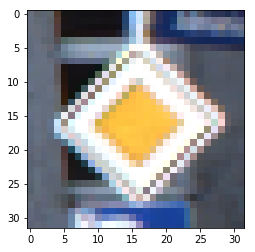

In [9]:
#set a random index
index = np.random.randint(0, len(X_test))
image = X_test[index].squeeze()
#Normalize and reshape image from 32x32x3 to 1x32x32x3
image_reshaped = normalize(image).reshape(1, 32,32,3)

#open a tensorflow session
with tf.Session() as sess:
    #retore previously session
    saver.restore(sess, tf.train.latest_checkpoint('.'))
    sess = tf.get_default_session()
    #feed, run and get result
    logit = sess.run(tf.argmax(logits, 1), feed_dict={x: image_reshaped})

plt.figure(figsize=(4,4))
plt.imshow(image, cmap="gray")

#print predicted and true label
print("True:", signnames.iloc[y_test[index], 1])
print("Predited:", signnames.iloc[logit[0], 1])
if signnames.iloc[y_test[index], 1] == signnames.iloc[logit[0], 1]:
    print("Right !")
else:
    print("Doesnt Match ")

In [10]:
cap = cv2.VideoCapture(0)
while(True):
        ret, img = cap.read()
        cv2.imshow('img',img)
        newimg = cv2.resize(img,(32,32))
        image = np.array((np.array(newimg)-128.)/128).reshape(1, 32,32,3)
        
        with tf.Session() as sess:
            saver.restore(sess, tf.train.latest_checkpoint('.'))
    
            sess = tf.get_default_session()
            logit = sess.run(tf.argmax(logits, 1), feed_dict={x: image})
        print(signnames.iloc[logit[0], 1])
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break

cap.release()
cv2.destroyAllWindows()

INFO:tensorflow:Restoring parameters from .\lenet
Beware of ice/snow
INFO:tensorflow:Restoring parameters from .\lenet
Beware of ice/snow
INFO:tensorflow:Restoring parameters from .\lenet
Speed limit (30km/h)
INFO:tensorflow:Restoring parameters from .\lenet
Speed limit (30km/h)
INFO:tensorflow:Restoring parameters from .\lenet
Wild animals crossing
INFO:tensorflow:Restoring parameters from .\lenet
Wild animals crossing
INFO:tensorflow:Restoring parameters from .\lenet
Wild animals crossing
INFO:tensorflow:Restoring parameters from .\lenet
Wild animals crossing
INFO:tensorflow:Restoring parameters from .\lenet
Wild animals crossing
INFO:tensorflow:Restoring parameters from .\lenet
Wild animals crossing
INFO:tensorflow:Restoring parameters from .\lenet
Wild animals crossing
INFO:tensorflow:Restoring parameters from .\lenet
Wild animals crossing
INFO:tensorflow:Restoring parameters from .\lenet
Wild animals crossing
INFO:tensorflow:Restoring parameters from .\lenet
Wild animals crossing


Dangerous curve to the left
INFO:tensorflow:Restoring parameters from .\lenet
Slippery road
INFO:tensorflow:Restoring parameters from .\lenet
Beware of ice/snow
INFO:tensorflow:Restoring parameters from .\lenet
Traffic signals
INFO:tensorflow:Restoring parameters from .\lenet
Beware of ice/snow
INFO:tensorflow:Restoring parameters from .\lenet
Turn left ahead
INFO:tensorflow:Restoring parameters from .\lenet
Bumpy road
INFO:tensorflow:Restoring parameters from .\lenet
Bumpy road
INFO:tensorflow:Restoring parameters from .\lenet
Turn left ahead
INFO:tensorflow:Restoring parameters from .\lenet
Turn left ahead
INFO:tensorflow:Restoring parameters from .\lenet
Turn left ahead
INFO:tensorflow:Restoring parameters from .\lenet
Turn left ahead
INFO:tensorflow:Restoring parameters from .\lenet
Turn left ahead
INFO:tensorflow:Restoring parameters from .\lenet
Turn left ahead
INFO:tensorflow:Restoring parameters from .\lenet
Turn left ahead
INFO:tensorflow:Restoring parameters from .\lenet
Turn

No passing for vehicles over 3.5 metric tons
INFO:tensorflow:Restoring parameters from .\lenet
No passing for vehicles over 3.5 metric tons
INFO:tensorflow:Restoring parameters from .\lenet
Speed limit (70km/h)
INFO:tensorflow:Restoring parameters from .\lenet
Turn left ahead
INFO:tensorflow:Restoring parameters from .\lenet
Roundabout mandatory
INFO:tensorflow:Restoring parameters from .\lenet
Speed limit (30km/h)
INFO:tensorflow:Restoring parameters from .\lenet
Go straight or right
INFO:tensorflow:Restoring parameters from .\lenet
Go straight or right
INFO:tensorflow:Restoring parameters from .\lenet
Turn right ahead
INFO:tensorflow:Restoring parameters from .\lenet
Go straight or right
INFO:tensorflow:Restoring parameters from .\lenet
Go straight or right
INFO:tensorflow:Restoring parameters from .\lenet
Go straight or right
INFO:tensorflow:Restoring parameters from .\lenet
Keep left
INFO:tensorflow:Restoring parameters from .\lenet
Go straight or right
INFO:tensorflow:Restoring pa